In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from livelossplot import PlotLosses
import time
import copy
import sys
from tqdm import tqdm
from channel_shuffle import ChannelShuffle

In [2]:
# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=30,
            translate=(0.1, 0.1),
            scale=(0.8, 1.2),
            shear=10
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

data_dir = 'tiny-imagenet-200'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=48,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


In [3]:
# Load ResNet18
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)  # Adjust final fully connected layer for 200 classes in Tiny ImageNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Multi GPU
if torch.cuda.device_count() > 1:
    model_ft = nn.DataParallel(model_ft)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Learning Rate Scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# Training function
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()
    liveloss = PlotLosses()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for progress bar
            with tqdm(total=dataset_sizes[phase], desc=f'{phase} Epoch {epoch+1}/{num_epochs}', unit='img') as pbar:
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    pbar.update(inputs.size(0))

                # Calculate epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                # Print epoch statistics
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # Deep copy the model if it performs better on validation set
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                # Update live plot
                if phase == 'val':
                    liveloss.update({
                        'val_loss': epoch_loss,
                        'val_accuracy': epoch_acc
                    })
                else:
                    liveloss.update({
                        'log loss': epoch_loss,
                        'accuracy': epoch_acc
                    })

            # Draw live plot
            liveloss.draw()

        # Step the scheduler
        scheduler.step()

        print()

    # Print final results
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_ft = train_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 1/25
----------


train Epoch 1/25:   2%|▏         | 1776/100000 [00:52<40:47, 40.14img/s] 

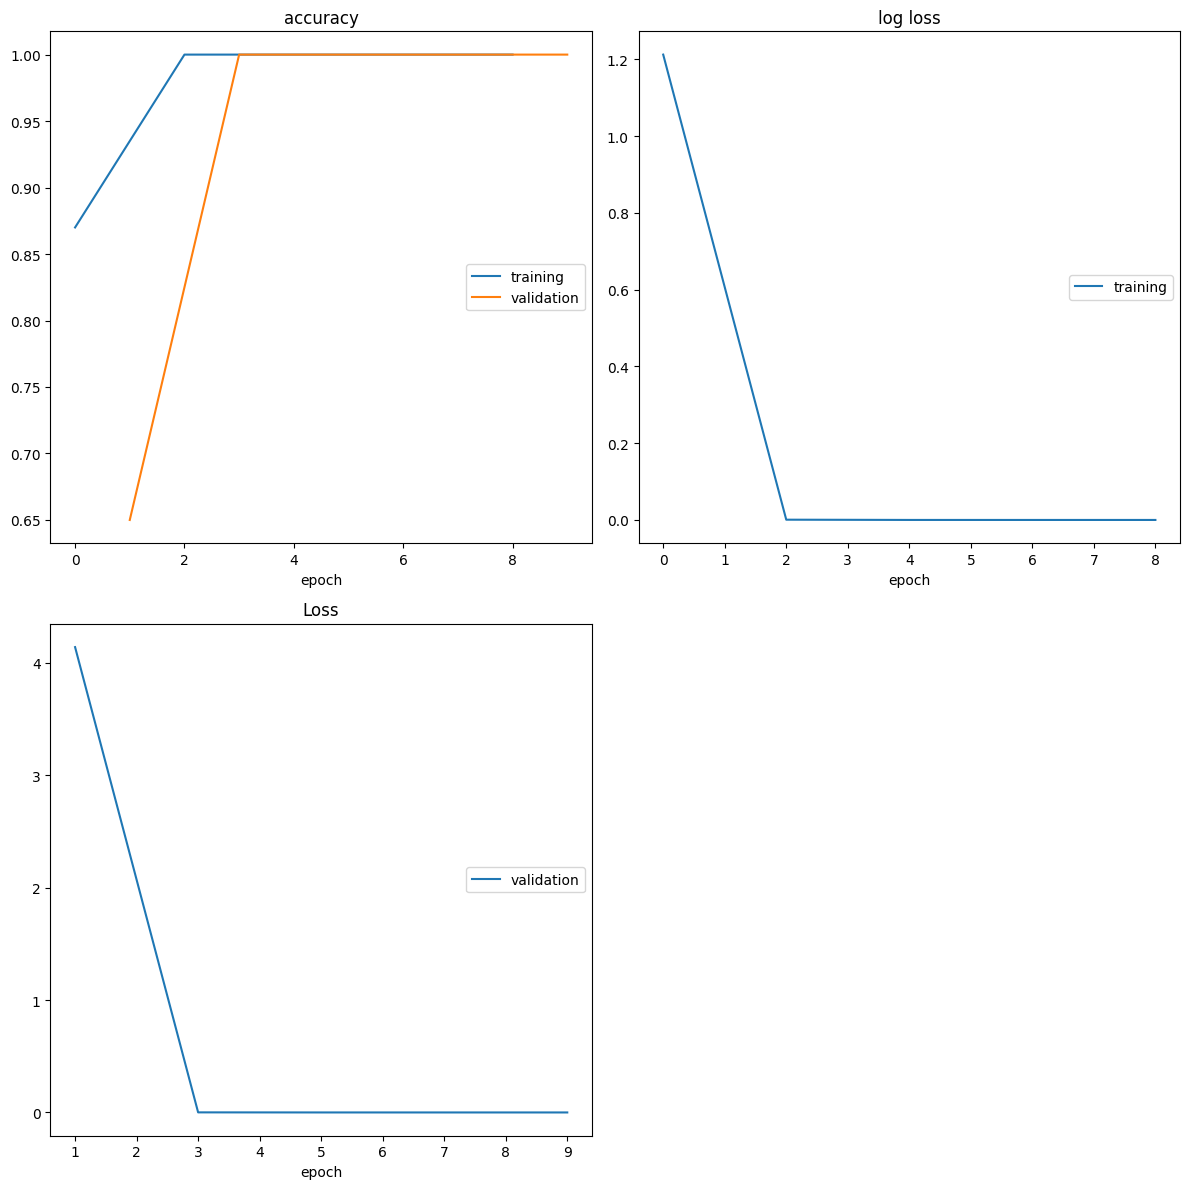

accuracy
	training         	 (min:    0.870, max:    1.000, cur:    1.000)
	validation       	 (min:    0.650, max:    1.000, cur:    1.000)
log loss
	training         	 (min:    0.000, max:    1.212, cur:    0.000)
Loss
	validation       	 (min:    0.000, max:    4.141, cur:    0.000)

Training complete in 5m 30s
Best val Acc: 1.000000


In [2]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, SubsetRandomSampler
from livelossplot import PlotLosses
import time
import copy
from tqdm import tqdm

# Load ResNet18
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)  # Adjust final fully connected layer for 200 classes in Tiny ImageNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Multi GPU
if torch.cuda.device_count() > 1:
    model_ft = nn.DataParallel(model_ft)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Learning Rate Scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

data_dir = 'tiny-imagenet-200'

# Load datasets with a small subset of 100 images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

# Select exactly 100 images for both training and validation
indices = list(range(100))
train_subset = torch.utils.data.Subset(image_datasets['train'], indices)
val_subset = torch.utils.data.Subset(image_datasets['train'], indices)

# Define batch size
batch_size = 50  # Reduce batch size for smaller subset

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()
    liveloss = PlotLosses()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for progress bar
            with tqdm(total=len(data_loader.dataset), desc=f'{phase} Epoch {epoch+1}/{num_epochs}', unit='img') as pbar:
                # Iterate over data.
                for inputs, labels in data_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    pbar.update(inputs.size(0))

                # Calculate epoch loss and accuracy
                epoch_loss = running_loss / len(data_loader.dataset)
                epoch_acc = running_corrects.double() / len(data_loader.dataset)

                # Print epoch statistics
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # Deep copy the model if it performs better on validation set
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                # Update live plot
                if phase == 'val':
                    liveloss.update({
                        'val_loss': epoch_loss,
                        'val_accuracy': epoch_acc
                    })
                else:
                    liveloss.update({
                        'log loss': epoch_loss,
                        'accuracy': epoch_acc
                    })

            # Draw live plot
            liveloss.draw()

        # Step the scheduler
        scheduler.step()

        print()

    # Print final results
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_ft = train_model(model_ft, train_loader, val_loader, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

In [1]:
import os

def print_directory_structure(root_dir, indent_level=0):
    # Print the current directory with appropriate indentation
    indent = ' ' * (indent_level * 4)
    print(f"{indent}{os.path.basename(root_dir)}/")
    
    # List all the files and directories in the current directory
    with os.scandir(root_dir) as it:
        for entry in it:
            if entry.is_dir():
                # Recursively print the directory structure for subdirectories
                print_directory_structure(entry.path, indent_level + 1)
            else:
                # Print the file name with appropriate indentation
                print(f"{indent}    {entry.name}")

# Specify the root directory you want to print
root_directory = '/tiny-imagenet-200'

# Print the directory structure starting from the root directory
print_directory_structure(root_directory)


tiny-imagenet-200/


FileNotFoundError: [Errno 2] No such file or directory: '/tiny-imagenet-200'